# Transfer learning - garbage classification

### Import and Inspect Data

In [1]:
import zipfile

zip_ref = zipfile.ZipFile("drive/MyDrive/garbage.zip")
zip_ref.extractall()
zip_ref.close()

In [2]:
import os 

for dirpath,dirname,filenames in os.walk("garbage"):
  print(dirpath,len(dirname),len(filenames))

garbage 2 1
garbage/train 4 1
garbage/train/trash 0 131
garbage/train/metal 0 376
garbage/train/cardboard 0 391
garbage/train/glass 0 488
garbage/test 4 1
garbage/test/trash 0 6
garbage/test/metal 0 34
garbage/test/cardboard 0 12
garbage/test/glass 0 13


### Image Preprocessing

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

#preprocess data
train_datagen = IDG(rescale=1./224,
                    rotation_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True)

valid_datagen = IDG(rescale=1./224)

#paths
train_dir = "garbage/train"
test_dir = "garbage/test"

#import data and turn to batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="categorical",
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="categorical",
                                               seed=42)

Found 1386 images belonging to 4 classes.
Found 65 images belonging to 4 classes.


### setting up callbacks

e.g:
* tracking experiments via TensorBoard
* Model checkpoint 
* Stopping model before overfitting

In [4]:
#tensorboard
import datetime
import tensorflow as tf

def tensorboard_callback(dir_name, exp_name):
  log_dir = f"{dir_name}/{exp_name}/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
  callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"saving tensorboard to: {log_dir}")
  return callback

### using tensorflow hub

In [5]:
import tensorflow_hub as hub

def create_model(url,num_classes=4):
  
  """
  uses tfhub url to create uncompiled sequential model
  url -> feature extraction url
  """

  extractor_layer = hub.KerasLayer(url,
                                   trainable=False,
                                   name="feature_extraction_layer",
                                   input_shape=(224,224,3))
    
  model = tf.keras.Sequential([
      extractor_layer,
      tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

effnet = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
resnet = "https://tfhub.dev/tensorflow/resnet_50/classification/1"

### ResNet model

In [6]:
resnet_model = create_model(resnet)

In [7]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1001)             25612201  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 4)                 4008      
                                                                 
Total params: 25,616,209
Trainable params: 4,008
Non-trainable params: 25,612,201
_________________________________________________________________


In [8]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

resnet_tfboard = tensorboard_callback("tensorflow_hub","resnet50V2")
resnet_history = resnet_model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    validation_steps=len(valid_data),
                    callbacks=[resnet_tfboard]
                    )

saving tensorboard to: tensorflow_hub/resnet50V2/20221103-022031
Epoch 1/5
44/44 [==============================] - 35s 455ms/step - loss: 1.3708 - accuracy: 0.4993 - val_loss: 1.3562 - val_accuracy: 0.5077
Epoch 2/5
44/44 [==============================] - 18s 404ms/step - loss: 1.3363 - accuracy: 0.6385 - val_loss: 1.3300 - val_accuracy: 0.4769
Epoch 3/5
44/44 [==============================] - 21s 468ms/step - loss: 1.3048 - accuracy: 0.6623 - val_loss: 1.3061 - val_accuracy: 0.4923
Epoch 4/5
44/44 [==============================] - 18s 406ms/step - loss: 1.2761 - accuracy: 0.6688 - val_loss: 1.2815 - val_accuracy: 0.5077
Epoch 5/5
44/44 [==============================] - 19s 429ms/step - loss: 1.2478 - accuracy: 0.6645 - val_loss: 1.2600 - val_accuracy: 0.4923


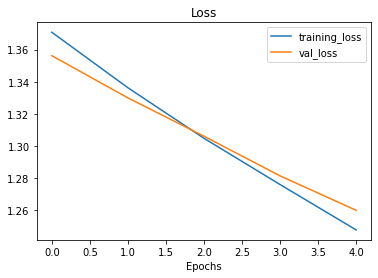

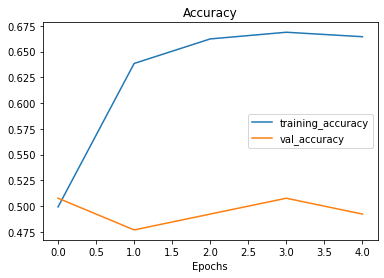

In [9]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(resnet_history)

In [10]:
import pathlib 
import numpy as np

data_dir = pathlib.Path("garbage/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))[1:]
class_names

array(['cardboard', 'glass', 'metal', 'trash'], dtype='<U9')

In [11]:
def load_and_prep_image(filename, img_shape=224):
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  img = img/255.
  return img

def pred_and_plot(model, filename, class_names):
  img = load_and_prep_image(filename)
  pred = model.predict(tf.expand_dims(img, axis=0))
  print(pred)
  pred_class = class_names[max([i for i in range(len(pred[0]))], key=lambda i:pred[0][i])] #could by multiclass or binary
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);



1/1 [==============================] - 1s 615ms/step
[[0.21814853 0.3247147  0.28008825 0.17704852]]


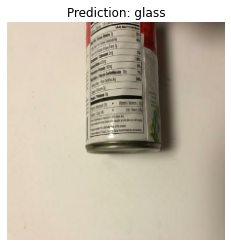

In [12]:
pred_and_plot(resnet_model,"/content/garbage/test/metal/metal395.jpg",class_names)

In [14]:
#resnet_model.save("garbage-classification-model")

In [15]:
#!zip -r garbage-classifcation-model.zip /content/garbage-classification-model

### Effnet 

In [30]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer") #normalizing not needed for efficientnet
x = base_model(inputs)
#print(x.shape)
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)
#print(x.shape)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(4, activation="softmax", name="output_layer")(x)

effnet_model = tf.keras.Model(inputs, outputs)

In [31]:
effnet_model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [32]:
effnet_history = effnet_model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    validation_steps=len(valid_data),
                    )

Epoch 1/5
44/44 [==============================] - 30s 512ms/step - loss: 1.3243 - accuracy: 0.3189 - val_loss: 1.4293 - val_accuracy: 0.2000
Epoch 2/5
44/44 [==============================] - 18s 407ms/step - loss: 1.3104 - accuracy: 0.3442 - val_loss: 1.4194 - val_accuracy: 0.1538
Epoch 3/5
44/44 [==============================] - 17s 396ms/step - loss: 1.3266 - accuracy: 0.3297 - val_loss: 1.2762 - val_accuracy: 0.2000
Epoch 4/5
44/44 [==============================] - 19s 441ms/step - loss: 1.3091 - accuracy: 0.3355 - val_loss: 1.3744 - val_accuracy: 0.2000
Epoch 5/5
44/44 [==============================] - 18s 404ms/step - loss: 1.3120 - accuracy: 0.3478 - val_loss: 1.4331 - val_accuracy: 0.2000


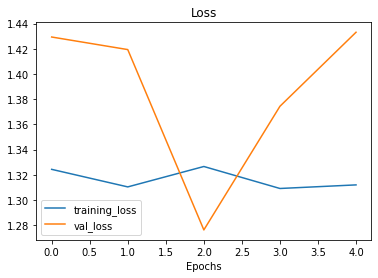

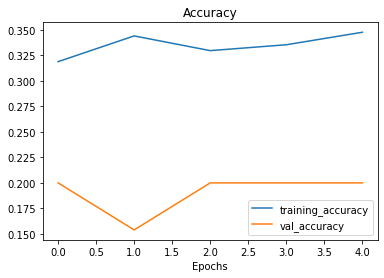

In [33]:
plot_loss_curves(effnet_history)

###ResNet With Fine Tuning

In [78]:
base_model = tf.keras.applications.ResNet50(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer") #normalizing not needed for efficientnet
x = base_model(inputs)
#print(x.shape)
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)
#print(x.shape)
x = tf.keras.layers.Flatten()(x)
x = outputs = tf.keras.layers.Dense(4)(x)
outputs = tf.keras.layers.Dense(4, activation="softmax", name="output_layer")(x)

resnet_fine_model = tf.keras.Model(inputs, outputs)

In [80]:
resnet_fine_model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), #rule of thumb is to lower lr for fine-tuning
              metrics=["accuracy"])

In [81]:
#train first for a few epochs

history = resnet_fine_model.fit(train_data,
                                epochs=5,
                                steps_per_epoch=len(train_data),
                                validation_data=valid_data,
                                validation_steps=len(valid_data))

Epoch 1/5
44/44 [==============================] - 24s 421ms/step - loss: 1.3880 - accuracy: 0.3038 - val_loss: 1.3290 - val_accuracy: 0.2769
Epoch 2/5
44/44 [==============================] - 19s 421ms/step - loss: 1.2713 - accuracy: 0.3745 - val_loss: 1.3347 - val_accuracy: 0.2769
Epoch 3/5
44/44 [==============================] - 18s 399ms/step - loss: 1.2453 - accuracy: 0.4127 - val_loss: 1.2450 - val_accuracy: 0.4154
Epoch 4/5
44/44 [==============================] - 21s 486ms/step - loss: 1.2404 - accuracy: 0.4495 - val_loss: 1.0261 - val_accuracy: 0.6769
Epoch 5/5
44/44 [==============================] - 18s 405ms/step - loss: 1.2325 - accuracy: 0.4401 - val_loss: 1.1604 - val_accuracy: 0.4769


In [82]:
base_model.trainable = True
for layer in base_model.layers[:-10]: layer.trainable=False

In [83]:
resnet_fine_model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #rule of thumb is to lower lr for fine-tuning
              metrics=["accuracy"])

In [84]:
#continue training with fine tuning (layers unfrozen), an extra 3 epochs
resnet_fine_history = resnet_fine_model.fit(train_data,
                    epochs=5+3,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    validation_steps=len(valid_data),
                    initial_epoch=history.epoch[-1]) #start training where last model left off

Epoch 5/8
44/44 [==============================] - 24s 467ms/step - loss: 1.1804 - accuracy: 0.5079 - val_loss: 1.6710 - val_accuracy: 0.3385
Epoch 6/8
44/44 [==============================] - 18s 400ms/step - loss: 1.0313 - accuracy: 0.5765 - val_loss: 1.7678 - val_accuracy: 0.3692
Epoch 7/8
44/44 [==============================] - 19s 430ms/step - loss: 0.9820 - accuracy: 0.5974 - val_loss: 1.5640 - val_accuracy: 0.2154
Epoch 8/8
44/44 [==============================] - 18s 397ms/step - loss: 0.9219 - accuracy: 0.6328 - val_loss: 1.5120 - val_accuracy: 0.2000


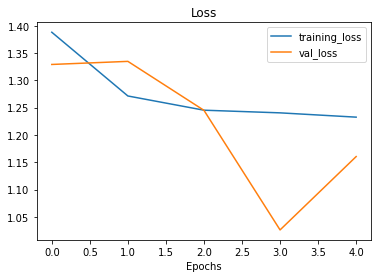

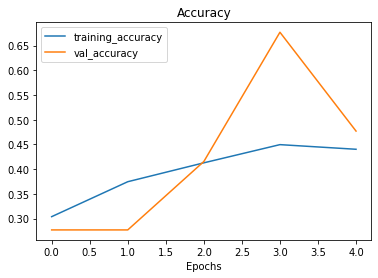

In [85]:
plot_loss_curves(history)

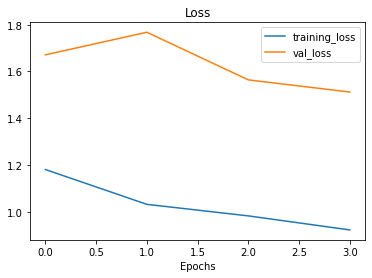

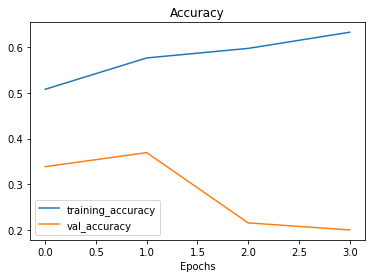

In [86]:
plot_loss_curves(resnet_fine_history)

### Detect With Real Photos 

In [16]:
import cv2
import uuid
import time

In [17]:
!mkdir {'/content/garbage/test_img'}

In [18]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [19]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [20]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [21]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [22]:
import uuid #coul

try:
  filename = take_photo('/content/garbage/test_img/photos.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

NotFoundError: Requested device not found


In [23]:
pred_and_plot(resnet_model,"/content/garbage/test_img/photos.jpg",class_names)

NotFoundError: ignored